In [1]:
import cobra
import os
import pandas
import glob

# Matplotlib defaults
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['figure.dpi'] = 300
#Rivanna fonts should include sans-serif now, but this could still raise an error
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

SMALLER_SIZE = 8
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
all_Rxns = pandas.read_csv("/home/mac9jc/paradigm/data/results/rxn_presence_before_gapfilling_24_03_2021.csv")
all_Rxns.rename(columns = {'Unnamed: 0':'reaction'}, inplace = True)


In [3]:
unique_rxns = all_Rxns[all_Rxns.sum(axis=1) ==1]

In [4]:
model_dict = dict()
path = "/home/mac9jc/paradigm/models/"
os.chdir(path)
for filename in glob.glob(os.path.join(path, 'gf_*.xml')):
    key = filename.split('/')[len(filename.split('/'))-1]
    key = key[:-4]
    key = key[3:]
    model_dict[key] = cobra.io.read_sbml_model(filename)
    

In [5]:
percent_both = dict()
percent_blocked = dict()
percent_unconnected_upstream = dict()
overall_unique_reactions = dict()
n_overall_unique_reactions = dict()
blocked = dict()
unconnected_upstream = dict()
both = dict()

for species, model in model_dict.items():
    blocked_down_rxns = list()
    blocked_up_rxns = list()
    both_rxns = list()
    model_reactions = [r.id for r in model.reactions]
    unique_reactions = list(set(unique_rxns[['reaction']]['reaction']).intersection(set(model_reactions)))
    overall_unique_reactions[species] = unique_reactions
    n_overall_unique_reactions[species] = len(unique_reactions)
    for x in unique_reactions:
        rxn = model.reactions.get_by_id(x)
        rxn_products = rxn.products
        rxn_reactants = rxn.reactants
        temp_dict = dict()
        for met in rxn_products:
            temp_dict[met] = [r.id for r in met.reactions if met in r.reactants]
        if len([met.id for met in temp_dict.keys() if len(temp_dict[met])<1])>1:
            blocked_down_rxns.append(x)
        temp_dict = dict()
        for met in rxn_reactants:
            temp_dict[met] = [r.id for r in met.reactions if met in r.products]
        if len([met.id for met in temp_dict.keys() if len(temp_dict[met])<1])>1:
            blocked_up_rxns.append(x)
        if x in blocked_up_rxns and x in blocked_down_rxns:
            both_rxns.append(x)
        
        #if x in both_rxns or x in blocked_up_rxns or x in blocked_down_rxns: print({species: x})
        
    blocked[species] = blocked_down_rxns
    unconnected_upstream[species] = blocked_up_rxns
    both[species] = both_rxns
    
    if n_overall_unique_reactions[species] >0:
        percent_both[species] = 100*len(both_rxns)/n_overall_unique_reactions[species]
        percent_blocked[species] = 100*len(blocked_down_rxns)/n_overall_unique_reactions[species]
        percent_unconnected_upstream[species] = 100*len(blocked_up_rxns)/n_overall_unique_reactions[species]
    else:
        percent_both[species] = 0
        percent_blocked[species] = 0
        percent_unconnected_upstream[species] = 0

In [6]:
n_overall_unique_reactions = pandas.DataFrame.from_dict(n_overall_unique_reactions, orient='index', columns = ['total unique rxns'])
percent_blocked = pandas.DataFrame.from_dict(percent_blocked, orient='index', columns = ['blocked'])
percent_unconnected_upstream = pandas.DataFrame.from_dict(percent_unconnected_upstream, orient='index', columns = ['unconnected'])
percent_both = pandas.DataFrame.from_dict(percent_both, orient='index', columns = ['both'])

df = n_overall_unique_reactions.copy()
df = df.merge(percent_blocked, left_index = True, right_index = True)
df = df.merge(percent_unconnected_upstream, left_index = True, right_index = True)
df = df.merge(percent_both, left_index = True, right_index = True)

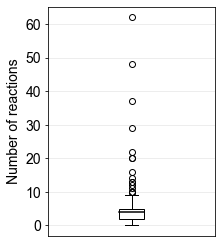

In [7]:

fig,ax = plt.subplots(figsize = (3, 6))
bplot = ax.boxplot([n_overall_unique_reactions['total unique rxns'].tolist()],
                   patch_artist=True,
                   medianprops = dict(color="black",linewidth=1.5), labels = ['']) 
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
colors = ["white"]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")
plt.subplots_adjust(bottom = 0.35)
ax.set_ylabel('Number of reactions')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

fig.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/unique_reactions_total.svg")
fig.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/unique_reactions_total.png")

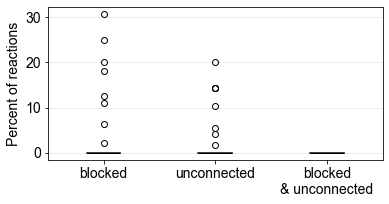

In [8]:

fig,ax = plt.subplots()
x = ['blocked','unconnected', 'blocked\n& unconnected']
bplot = ax.boxplot([percent_blocked['blocked'].tolist(), percent_unconnected_upstream['unconnected'].tolist(), percent_both['both'].tolist()],
                   patch_artist=True,
                   medianprops = dict(color="black",linewidth=1.5), labels = x) 
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
colors = ["white","white","white","white","white"]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")
plt.subplots_adjust(bottom = 0.35)
ax.set_ylabel('Percent of reactions')
plt.show()

fig.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/unique_reactions.svg")
fig.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/unique_reactions.png")


In [9]:
df2 = df.copy()
df2.rename(columns = {'total unique rxns':'total'}, inplace = True)
df2['blocked_num'] = df2['total'] * df2['blocked']/100
df2['unconnected_num'] = df2['total'] * df2['unconnected']/100
df2['both_num'] = df2['total'] * df2['both']/100
del df2['blocked']
del df2['unconnected']
del df2['both']
df2.rename(columns = {'blocked_num':'blocked','unconnected_num':'unconnected','both_num':'both'}, inplace = True)
df2['connected'] = df2.apply(lambda row: row.total - (row.blocked + row.unconnected + row.both), axis=1)
del df2['total']
df2.head()

,blocked,unconnected,both,connected
no_ortho_EcuniculiEC3,0.0,0.0,0.0,5.0
no_ortho_TevansiSTIB805,0.0,0.0,0.0,1.0
PfalciparumTG01,0.0,0.0,0.0,5.0
no_ortho_TgondiiARI,0.0,0.0,0.0,3.0
no_ortho_TcruziCLBrenerNon-Esmeraldo-like,0.0,0.0,0.0,2.0


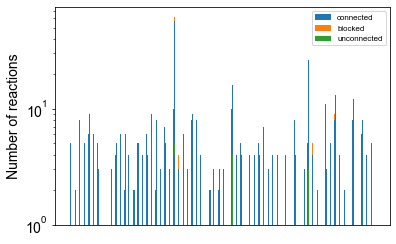

In [10]:
labels = df2.index
first = df2[['connected']]['connected']
second = df2[['blocked']]['blocked']
third = df2[['unconnected']]['unconnected']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
ax.bar(labels, first, width, label='connected')
ax.bar(labels, second, width, bottom=first, label='blocked')
ax.bar(labels, third, width, bottom=second, label='unconnected')

ax.set_ylabel('Number of reactions')
ax.legend()
ax.axes.get_xaxis().set_visible(False)
plt.yscale("log")
plt.show()

fig.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/unique_reactions_connectivity.svg")
fig.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/unique_reactions_connectivity.png")

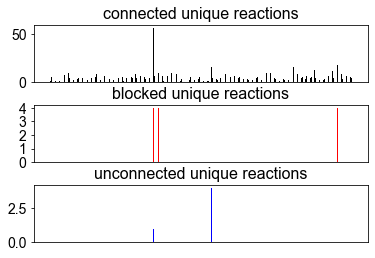

In [11]:

#fig, axs = plt.subplots(3, sharex=True, sharey=False, gridspec_kw={'hspace': 0})

# axs[0].bar(labels, first, width, label='connected')
# axs[1].bar(labels, second, width, bottom=first, label='blocked')
# axs[2].bar(labels, third, width, bottom=second, label='unconnected')
    
# axs[0].axes.get_xaxis().set_visible(False)
# axs[1].axes.get_xaxis().set_visible(False)
# axs[2].axes.get_xaxis().set_visible(False)

# plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.bar(labels, first, width, label='connected', color = "black")
ax1.axes.get_xaxis().set_visible(False)
ax1.set_title('connected unique reactions')
ax1.axes.get_xaxis().set_visible(False)
ax2.bar(labels, second, width, label='blocked', color = "red")
ax2.axes.get_xaxis().set_visible(False)
ax2.set_title('blocked unique reactions')
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax3.bar(labels, third, width, label='unconnected', color = "blue")
ax3.axes.get_xaxis().set_visible(False)
ax3.set_title('unconnected unique reactions')
ax3.axes.get_xaxis().set_visible(False)
plt.subplots_adjust(wspace=.1, hspace=.4)

fig.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/unique_reactions_connectivity.svg")
fig.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/unique_reactions_connectivity.png")